<a href="https://colab.research.google.com/github/Abhijeet8901/Instance-Segmentation-using-YOLACT/blob/main/YOLACT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import sampler
import torchvision.datasets as dset

import time
from google.colab.patches import cv2_imshow
import pickle
import cv2
import numpy as np
import glob
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchsummary import summary

dtype = torch.cuda.FloatTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('drive/My Drive/YOLACT')
from box_utils import *
from coco import *
from augmentations import *
from config import *

cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
class set_config:

  def __init__(self):
    self.img_size=550
    self.num_anchors=3
    self.num_classes=21
    self.mode='train'
    self.scales=[32, 64, 128, 256, 512]
    self.aspect_ratios  = [1, 1 / 2, 2]
    self.batch_size=8
    self.pos_iou_thre=0.5
    self.neg_iou_thre=0.4
    self.np_ratio=3
    self.conf_alpha = 1
    self.bbox_alpha = 1.5
    self.mask_alpha = 6.125
    self.semantic_alpha = 1
    self.max_detections = 100
    self.resume=True
    self.test_image_path="drive/My Drive/Personal/Abhijeet.jpg"
    self.video=None#"drive/My Drive/Personal/test_video.mp4"
    self.label_id={}
    for idx,class1 in enumerate(PASCAL_CLASSES):
      self.label_id[class1]=idx
    self.lr=0.001
    self.cfg_name="resnet_pascal"
    self.save_lincomb=False
    self.visual_thre=0.3
    self.nms_score_thre = 0.05
    self.nms_iou_thre = 0.5
    self.top_k = 200
    self.no_crop=False
    self.hide_mask=False
    self.hide_bbox=False
    self.hide_score=False
    self.cutout=False
    self.real_time=False
    self.class_names = PASCAL_CLASSES

cfg=set_config()

In [82]:
class BottleNeck(nn.Module):
  
    def __init__(self,inplanes,planes,stride=1,downsample=None):
        super().__init__()
        self.conv1=nn.Conv2d(inplanes,planes,kernel_size=1,bias=False)
        self.bn1=nn.BatchNorm2d(planes)
        self.conv2=nn.Conv2d(planes,planes,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2=nn.BatchNorm2d(planes)
        self.conv3=nn.Conv2d(planes,4*planes,kernel_size=1,bias=False)
        self.bn3=nn.BatchNorm2d(4*planes)
        self.relu=nn.ReLU(inplace=True)
        self.downsample=downsample

    def forward(self,x):

        residual=x
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)
        out=self.conv2(out)
        out=self.bn2(out)
        out=self.relu(out)
        out=self.conv3(out)
        out=self.bn3(out)
        
        if self.downsample != None:
          residual=self.downsample(x)
        
        out+=residual
        out=self.relu(out)

        return out

class Resnet_Backbone(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.inplanes=64

        self.conv1=nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU(inplace=True)
        self.pool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.layer1=self.set_bottleneck(64,3)
        self.layer2=self.set_bottleneck(128,4,stride=2)
        self.layer3=self.set_bottleneck(256,6,stride=2)
        self.layer4=self.set_bottleneck(512,3,stride=2)

        self.backbone_modules = [m for m in self.modules() if isinstance(m, nn.Conv2d)]

    def set_bottleneck(self,planes,num_of_necks,stride=1):

        downsample=None
        layers=[]
        if stride !=1 or self.inplanes != 4*planes:
          downsample=nn.Sequential(nn.Conv2d(self.inplanes,4*planes,kernel_size=1,
                                              stride=stride,bias=False),
                                    nn.BatchNorm2d(4*planes))
        layers.append(BottleNeck(self.inplanes,planes,stride,downsample))
        
        num_of_necks-=1
        self.inplanes=4*planes
        
        for i in range(num_of_necks):
          layers.append(BottleNeck(self.inplanes,planes))
        
        return nn.Sequential(*layers)
  
    def forward(self,x):

        out=self.pool(self.relu(self.bn1(self.conv1(x))))

        outs=[]

        out=self.layer1(out)
        out=self.layer2(out)
        outs.append(out)
        out=self.layer3(out)
        outs.append(out)
        out=self.layer4(out)
        outs.append(out)

        return tuple(outs)
    
    def init_backbone(self,state_dic):
      self.load_state_dict(state_dic,strict=False)

In [83]:
class FPN(nn.Module):

    def __init__(self):
        super().__init__()

        self.sizes=[512,1024,2048]
        self.lat_layers=nn.ModuleList()
        self.dealiasing_layers=nn.ModuleList()
        self.downsample_layer=nn.ModuleList()
        for i in range(3):
          self.lat_layers.append(nn.Conv2d(self.sizes[i],256,kernel_size=1))
          self.dealiasing_layers.append(nn.Conv2d(256,256,kernel_size=3,padding=1))
          if i!=2:
            self.downsample_layer.append(nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1))

    def forward(self,input_outs):

        outs=[]
        x=x = torch.zeros(1,device=device)
        for i in reversed(range(3)):
          if i!=2:
            _,_,h,w=input_outs[i].shape
            x= F.interpolate(x,size=(h,w),mode='bilinear',align_corners=False)

          x=x+ self.lat_layers[i](input_outs[i])

          outs.append(F.relu(self.dealiasing_layers[i](x)))
        
        outs.reverse()

        for i in range(2):
          outs.append(self.downsample_layer[i](outs[-1]))

        return outs
   

In [84]:
class ProtoNet(nn.Module):

  def __init__(self):
      super().__init__()

      self.layer1=nn.ModuleList()
      for i in range(3):
        self.layer1.append(nn.Conv2d(256,256,kernel_size=3,padding=1))
        self.layer1.append(nn.ReLU(inplace=True))
      self.layer2=nn.Conv2d(256,256,kernel_size=3,padding=1)
      self.relu=nn.ReLU(inplace=True)
      self.layer3=nn.Conv2d(256,32,kernel_size=1)
  
  def forward(self,x):

      out=x
      for layer in self.layer1:
        out=layer(out)
      out=F.interpolate(out,(138,138),mode='bilinear',align_corners=False)
      out=self.relu(out)
      out=self.layer2(out)
      out=self.relu(out)
      out=self.layer3(out)
      out=self.relu(out)

      return out

In [85]:
class PredictionNet(nn.Module):

    def __init__(self):
      super().__init__()

      self.layer1=nn.Conv2d(256,256,kernel_size=3,padding=1)
      self.relu=nn.ReLU(inplace=True)
      self.box_layer=nn.Conv2d(256,cfg.num_anchors*4,kernel_size=3,padding=1)
      self.class_layer=nn.Conv2d(256,cfg.num_anchors*cfg.num_classes,kernel_size=3,padding=1)
      self.mask_layer=nn.Conv2d(256,cfg.num_anchors*32,kernel_size=3,padding=1)

    def forward(self,x):

      out=self.layer1(x)
      out=self.relu(out)
      box_pred=self.box_layer(out).permute(0,2,3,1).reshape(out.size(0),-1,4)
      class_pred=self.class_layer(out).permute(0,2,3,1).reshape(out.size(0),-1,cfg.num_classes)
      mask_pred=self.mask_layer(out).permute(0,2,3,1).reshape(out.size(0),-1,32)

      return class_pred,box_pred,mask_pred

In [86]:
class YOLACT(nn.Module):

    def __init__(self):
        super().__init__()

        self.backbone=Resnet_Backbone()
        self.fpn=FPN()
        self.protonet=ProtoNet()
        self.prediction_layers=PredictionNet()

        if cfg.mode=='train':
          self.semantic_layer=nn.Conv2d(256,cfg.num_classes-1,kernel_size=1)
    
    def forward(self,img,box_class_gt=None,mask_gt=None):

        backbone_outs=self.backbone(img)
        fpn_outs=self.fpn(backbone_outs)
        proto_out=self.protonet(fpn_outs[0])
        proto_out=proto_out.permute(0,2,3,1).contiguous()

        if cfg.mode == 'train':
          seg_out=self.semantic_layer(fpn_outs[0])

        class_pred,box_pred,mask_pred=[],[],[]

        for fpn_out in fpn_outs:
          class_p,box_p,mask_p=self.prediction_layers(fpn_out)
          class_pred.append(class_p)
          box_pred.append(box_p)
          mask_pred.append(mask_p)

        class_pred=torch.cat(class_pred,dim=1)
        box_pred=torch.cat(box_pred,dim=1)
        mask_pred=torch.cat(mask_pred,dim=1)

        anchors,shapes=[],[69,35,18,9,5]

        for i in range(5):
          anchors+=make_anchors(cfg,shapes[i],shapes[i],cfg.scales[i])

        anchors = torch.tensor(anchors, device=device).reshape(-1, 4)
        
        if self.training:
          return self.compute_loss(class_pred,box_pred,mask_pred,proto_out,seg_out,box_class_gt,mask_gt,anchors)
        
        else :
          class_pred=F.softmax(class_pred,-1)
          return class_pred,box_pred,mask_pred,proto_out,anchors

    def init_weights(self,state_dic):

        self.backbone.init_backbone(state_dic)

        for name,module in self.named_modules():

          if isinstance(module,nn.Conv2d) and module not in self.backbone.backbone_modules:
            nn.init.xavier_uniform_(module.weight.data)

            if module.bias is not None:
              module.bias.data.zero_()
    def load_weights(self,path):

        if torch.cuda.is_available():
            state_dict = torch.load(path)
        else:
            state_dict = torch.load(path, map_location='cpu')
        for key in list(state_dict.keys()):
          
          if key.startswith('fpn.downsample'):
            if int(key.split('.')[2])>=2:
              del state_dict[key]
          
          if cfg.mode!= 'train' and key.startswith('semantic'):
            del state_dict[key]
        
        self.load_state_dict(state_dict,strict=False)

    def compute_loss(self,class_p,box_p,coef_p,proto_p,seg_p,box_class_gt,mask_gt,anchors):
        
        class_gt=[None]*len(box_class_gt)
        num_anchors=anchors.size(0)
        batch_size=len(box_class_gt)
        offsets=torch.zeros((batch_size,num_anchors,4),dtype=torch.float32,device=device)
        conf_gt = torch.zeros((batch_size, num_anchors), dtype=torch.int64,device=device)
        anchor_max_gt = torch.zeros((batch_size, num_anchors, 4), dtype=torch.float32,device=device)
        anchor_max_i = torch.zeros((batch_size, num_anchors), dtype=torch.int64,device=device)

        for i in range(len(box_class_gt)):
          class_gt[i]=box_class_gt[i][:,-1].long()

          offsets[i],conf_gt[i],anchor_max_gt[i],anchor_max_i[i]=match(cfg,box_class_gt[i][:,:-1],anchors,class_gt[i])

        pos_bool = conf_gt>0

        loss_c = self.category_loss(class_p,conf_gt,pos_bool)
        loss_b = self.box_loss(box_p, offsets, pos_bool)
        loss_m = self.lincomb_mask_loss(pos_bool, anchor_max_i, coef_p, proto_p, mask_gt, anchor_max_gt)
        loss_s = self.semantic_seg_loss(seg_p, mask_gt, class_gt)

        return loss_c,loss_b,loss_m,loss_s

    def category_loss(self,class_p,conf_gt,pos_bool):

        # Negative examples may be way more than positive examples, so we dont use all negative examples, hence this bullshit
        batch_conf=class_p.reshape(-1,cfg.num_classes)

        max_conf=batch_conf.max()
        mark=torch.log(torch.sum(torch.exp(batch_conf-max_conf),1)) + max_conf - batch_conf[:,0]

        mark=mark.reshape(class_p.size(0),-1)
        mark[pos_bool]=0
        mark[conf_gt<0]=0

        _, idx = mark.sort(1, descending=True)
        _, idx_rank = idx.sort(1)

        num_pos = pos_bool.long().sum(1, keepdim=True)
        num_neg = torch.clamp(cfg.np_ratio * num_pos, max=pos_bool.size(1) - 1)
        neg_bool = idx_rank < num_neg.expand_as(idx_rank)

        neg_bool[pos_bool] = 0
        neg_bool[conf_gt < 0] = 0
        class_p_mined = class_p[(pos_bool + neg_bool)].reshape(-1, cfg.num_classes)
        class_gt_mined = conf_gt[(pos_bool + neg_bool)]

        return cfg.conf_alpha * F.cross_entropy(class_p_mined, class_gt_mined, reduction='sum') / num_pos.sum()

    def box_loss(self,box_p,offsets,pos_bool):

        num_pos = pos_bool.sum()
        pos_box_p = box_p[pos_bool, :]
        pos_offsets = offsets[pos_bool, :]

        return cfg.bbox_alpha * F.smooth_l1_loss(pos_box_p, pos_offsets, reduction='sum') / num_pos

    def lincomb_mask_loss(self, pos_bool, anchor_max_i, coef_p, proto_p, mask_gt, anchor_max_gt):

        proto_h, proto_w = proto_p.shape[1:3]
        total_pos_num = pos_bool.sum()
        loss_m = 0
        for i in range(coef_p.size(0)):
            downsampled_masks = F.interpolate(mask_gt[i].unsqueeze(0), (proto_h, proto_w), mode='bilinear',
                                              align_corners=False).squeeze(0)

            downsampled_masks = downsampled_masks.permute(1, 2, 0).contiguous()  
            
            downsampled_masks = downsampled_masks.gt(0.5).float()

            pos_anchor_i = anchor_max_i[i][pos_bool[i]]
            pos_anchor_box = anchor_max_gt[i][pos_bool[i]]
            pos_coef = coef_p[i][pos_bool[i]]

            if pos_anchor_i.size(0) == 0:
                continue

            old_num_pos = pos_coef.size(0)
            if old_num_pos > cfg.max_detections:
                perm = torch.randperm(pos_coef.size(0))
                select = perm[:
                              cfg.max_detections]
                pos_coef = pos_coef[select]
                pos_anchor_i = pos_anchor_i[select]
                pos_anchor_box = pos_anchor_box[select]

            num_pos = pos_coef.size(0)

            pos_mask_gt = downsampled_masks[:, :, pos_anchor_i]

            mask_p = torch.sigmoid(proto_p[i] @ pos_coef.t())
            mask_p = crop_(mask_p, pos_anchor_box)
            mask_loss = F.binary_cross_entropy(torch.clamp(mask_p, 0, 1), pos_mask_gt, reduction='none')

            anchor_area = (pos_anchor_box[:, 2] - pos_anchor_box[:, 0]) * (pos_anchor_box[:, 3] - pos_anchor_box[:, 1])
            mask_loss = mask_loss.sum(dim=(0, 1)) / anchor_area

            if old_num_pos > num_pos:
                mask_loss *= old_num_pos / num_pos

            loss_m += torch.sum(mask_loss)

        return cfg.mask_alpha * loss_m / proto_h / proto_w / total_pos_num

    def semantic_seg_loss(self, segmentation_p, mask_gt, class_gt):

        batch_size, num_classes, mask_h, mask_w = segmentation_p.size()
        loss_s = 0

        for i in range(batch_size):
            cur_segment = segmentation_p[i]
            cur_class_gt = class_gt[i]

            downsampled_masks = F.interpolate(mask_gt[i].unsqueeze(0), (mask_h, mask_w), mode='bilinear',
                                              align_corners=False).squeeze(0)
            downsampled_masks = downsampled_masks.gt(0.5).float()

            segment_gt = torch.zeros_like(cur_segment, requires_grad=False)
            for j in range(downsampled_masks.size(0)):
                segment_gt[cur_class_gt[j]] = torch.max(segment_gt[cur_class_gt[j]], downsampled_masks[j])

            loss_s += F.binary_cross_entropy_with_logits(cur_segment, segment_gt, reduction='sum')

        return cfg.semantic_alpha * loss_s / mask_h / mask_w / batch_size

In [87]:
# load weights for resnet to initialize with
from torchvision.models.resnet import resnet50

model=resnet50(pretrained=True)
model=model.to(device)

state_dict_pretrained=model.state_dict()
keys=list(state_dict_pretrained)
for i,key in enumerate(keys):
  if i==318 or i==319:
    state_dict_pretrained.pop(key)
keys=list(state_dict_pretrained)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [88]:
from zipfile import ZipFile
import zipfile
filename='SegmentationObject.zip'
with ZipFile(filename,'r') as zip:
  zip.extractall()

In [89]:
from numpy import asarray
def calc_mask(mask_path,num_objects):
    img = Image.open(mask_path)
    img=asarray(img)
    mask=np.zeros((img.shape[0],img.shape[1],num_objects))
    for i in range(num_objects):
        mask[:,:,i]=(img==i+1)
    mask=mask.transpose(2,0,1)
    return mask

In [90]:
class PascalLoader(data.Dataset): 

    def __init__(self,mode='train'):

      self.mode=mode
      self.cfg=cfg
      if self.mode=='train' or self.mode=='val':
        img_path="drive/My Drive/YOLACT/VOCdevkit/VOC2012/JPEGImages/*.*"
        mask_path="SegmentationObject/*.*"
        annot_file="drive/My Drive/YOLACT/annot_file.pkl"
        open_file=open(annot_file,'rb')
        self.boxes=pickle.load(open_file)
        open_file.close()
        self.image_pathlist=glob.glob(img_path)
        self.mask_pathlist=glob.glob(mask_path)
        self.image_pathlist.sort()
        self.mask_pathlist.sort()
        self.boxes
      
      elif self.mode=='detect':
        self.img_path=cfg.test_image_path

    def __getitem__(self,index):

      if self.mode=='detect':
        image=cv2.imread(self.img_path)
        image_normed=val_aug(image,cfg.img_size)
        return image_normed,image,self.img_path.split('/')[-1]

      else:
        image_path=self.image_pathlist[index]
        mask_path=self.mask_pathlist[index]
        all_box=self.boxes[index]
        img=cv2.imread(image_path)
        mask=cv2.imread(mask_path)
        height,width,_=img.shape
        box_list, label_list = [], []
        for box in all_box:
          x1y1x2y2_box = np.array([box[0], box[1],box[2], box[3]]).astype(float)
          category=self.cfg.label_id[box[4]]
          box_list.append(x1y1x2y2_box)
          label_list.append(category)
        
        if len(box_list)>0:

          masks=calc_mask(mask_path,len(box_list))
          boxes=np.array(box_list)
          labels=np.array(label_list)

          assert masks.shape==(boxes.shape[0], height, width)

          if self.mode == 'train':
            img, masks, boxes, labels = train_aug(img, masks, boxes, labels, self.cfg.img_size)
            if img is None:
              return None, None, None
            else:
              boxes = np.hstack((boxes, np.expand_dims(labels, axis=1)))
              return img, boxes, masks
          elif self.mode=='val':
            img = val_aug(img, self.cfg.img_size)
            boxes = boxes / np.array([width, height, width, height]) 
            boxes = np.hstack((boxes, np.expand_dims(labels, axis=1)))
            return img, boxes, masks, height, width
        else:
          print("No valid image")
          return None,None,None
      
    def __len__(self):
      if self.mode=='train':
        return len(self.image_pathlist)
      else:
        return 1

In [91]:
######################### Let's Train this Bitch #############################
import torch.backends.cudnn as cudnn
import torch.distributed as dist
torch.autograd.set_detect_anomaly(True)


net=YOLACT().to(device)
net.train()
cfg.mode='train'
if cfg.resume:
  path="drive/My Drive/YOLACT/weights/latest_resnet_pascal_102.pth"
  if torch.cuda.is_available():
    net.load_weights(path)
  else:
    net.load_weights(path)
  start_step = int(path.split('.pth')[0].split('_')[-1])
  print(f'\nResume training with \'{path}\'.\n')

else:
  net.init_weights(state_dict_pretrained)
  start_step=0

dataset = PascalLoader(mode='train')
optimizer =optim.SGD(net.parameters(),lr=cfg.lr,momentum=0.9,weight_decay=5e-4)
train_loader= DataLoader(dataset,cfg.batch_size,shuffle=True,collate_fn=train_collate)


Resume training with 'drive/My Drive/YOLACT/weights/latest_resnet_pascal_102.pth'.



In [93]:
################# Run this cell only for training, not for detection ############################
training=True
time_last=time.time()
step_no=start_step+1
while training:

  for i,(images,boxes,masks) in enumerate(train_loader):
    if torch.cuda.is_available():
      images = images.cuda().detach()
      boxes = [ann.cuda().detach() for ann in boxes]
      masks = [mask.cuda().detach() for mask in masks]
    loss_c, loss_b, loss_m, loss_s = net(images, boxes, masks)
    loss_total = loss_c + loss_b + loss_m + loss_s
    optimizer.zero_grad()
    loss_total.backward()
    optimizer.step()
    this_time=time.time()
    if i%30==0:
      print("Time taken Batch no ",i," is ",this_time-time_last,"Loss is ",loss_total.item())
    time_last=time.time()

  print("Epoch no ",step_no," is completed")
  save_latest(net,cfg.cfg_name,step_no)
  step_no+=1

Time taken Batch no  0  is  1.235675573348999 Loss is  4.335552215576172
Time taken Batch no  30  is  1.1826069355010986 Loss is  6.812966823577881
Time taken Batch no  60  is  1.1726195812225342 Loss is  5.630031108856201
Time taken Batch no  90  is  1.2070391178131104 Loss is  6.524414539337158
Time taken Batch no  120  is  1.1900653839111328 Loss is  5.754493236541748
Time taken Batch no  150  is  1.168647050857544 Loss is  7.180950164794922
Time taken Batch no  180  is  1.2279069423675537 Loss is  6.704204559326172
Time taken Batch no  210  is  1.1863601207733154 Loss is  6.429392337799072
Time taken Batch no  240  is  1.204770803451538 Loss is  6.260523796081543
Time taken Batch no  270  is  1.1622838973999023 Loss is  4.731888771057129
Time taken Batch no  300  is  1.1594815254211426 Loss is  13.76915168762207
Time taken Batch no  330  is  1.200467586517334 Loss is  5.106728553771973
Time taken Batch no  360  is  1.1570649147033691 Loss is  5.821977615356445
Epoch no  103  is com

KeyboardInterrupt: ignored

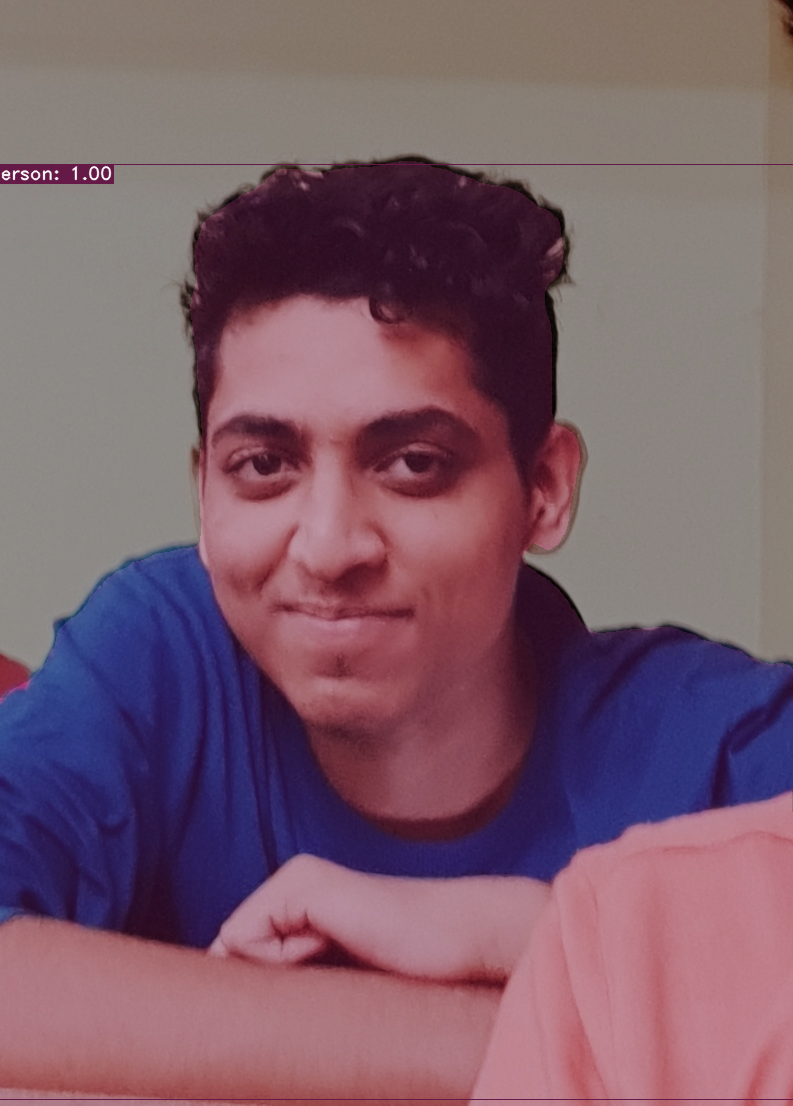

In [114]:
##################### Detection Begins Here ####################################
from output_utils import *
net=YOLACT().to(device)
path="drive/My Drive/YOLACT/weights/latest_resnet_pascal_111.pth"
cfg.test_image_path="drive/My Drive/YOLACT/test_images/test_img_4.jpg"
net.load_weights(path)
net.eval()
cfg.mode='detect'
with torch.no_grad():

  if cfg.test_image_path is not None:
    dataset= PascalLoader(mode='detect')
    data_loader=data.DataLoader(dataset,1,shuffle=False,pin_memory=True,collate_fn=detect_collate)
    for i, (img, img_origin, img_name) in enumerate(data_loader):
      
      if torch.cuda.is_available():
        img=img.cuda()
        img_h,img_w=img_origin.shape[0:2]
        class_p,box_p,coef_p,proto_p,anchors=net(img)

        ids_p, class_p, box_p, coef_p, proto_p = nms(class_p, box_p, coef_p, proto_p, anchors, cfg)
        ids_p, class_p, boxes_p, masks_p = after_nms(ids_p, class_p, box_p, coef_p,
                                                             proto_p, img_h, img_w, cfg, img_name=img_name)
        img_numpy = draw_img(ids_p, class_p, boxes_p, masks_p, img_origin, cfg, img_name=img_name)
        cv2_imshow(img_numpy)
        if cfg.real_time:
          cv2.imshow('Detection', frame_numpy)
          cv2.waitKey(1)
        else:
          cv2.imwrite('drive/My Drive/YOLACT/results/'+img_name, img_numpy)
  
  elif cfg.video is not None:
    vid = cv2.VideoCapture(cfg.video)
    target_fps = round(vid.get(cv2.CAP_PROP_FPS))
    frame_width = round(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = round(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    num_frames = round(vid.get(cv2.CAP_PROP_FRAME_COUNT))

    name = cfg.video.split('/')[-1]
    video_writer = cv2.VideoWriter(f'drive/MyDrive/YOLACT/results/{name}', cv2.VideoWriter_fourcc(*"mp4v"), target_fps,
                                       (frame_width, frame_height))
    t_fps = 0
    for i in range(num_frames):
      frame_origin = vid.read()[1]
      img_h, img_w = frame_origin.shape[0:2]
      frame_trans = val_aug(frame_origin, cfg.img_size)
      frame_tensor = torch.tensor(frame_trans).float()
      if torch.cuda.is_available():
        frame_tensor = frame_tensor.cuda()
      class_p, box_p, coef_p, proto_p, anchors = net(frame_tensor.unsqueeze(0))
      ids_p, class_p, box_p, coef_p, proto_p = nms(class_p, box_p, coef_p, proto_p, anchors, cfg)
      ids_p, class_p, boxes_p, masks_p = after_nms(ids_p, class_p, box_p, coef_p,
                                                             proto_p, img_h, img_w, cfg)
      frame_numpy = draw_img(ids_p, class_p, boxes_p, masks_p, frame_origin, cfg, fps=t_fps)
      video_writer.write(frame_numpy)
    vid.release()
    video_writer.release()

